In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

In [2]:
df = pd.read_csv('combined_traj_data.csv')

In [3]:
# Feature engineering
df['speed'] = np.sqrt(df['vx']**2 + df['vy']**2)
df['heading'] = np.arctan2(df['vy'], df['vx'])
df['accel'] = df['speed'].diff() / df['t'].diff()
df['turn_rate'] = df['heading'].diff() / df['t'].diff()
df['distance'] = np.sqrt(df['x'].diff()**2 + df['y'].diff()**2)

features = df[['speed', 'heading', 'accel', 'turn_rate', 'distance']]

In [ ]:
features['accel'].fillna(0, inplace=True)
features['turn_rate'].fillna(0, inplace=True)
features['distance'].fillna(0, inplace=True)

In [5]:
features.head()

,speed,heading,accel,turn_rate,distance
0,14.1,1.186824,0.000000,0.000000e+00,0.000000
1,14.0,1.186824,-0.001587,-2.819614e-17,0.004410
2,14.1,1.186824,0.004545,8.074349e-17,0.001710
3,14.0,1.186824,-0.003448,-6.125368e-17,0.001645
4,14.0,1.186824,0.000000,0.000000e+00,0.005133


In [6]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor()
y_pr = lof.fit_predict(features)

In [7]:
inlier_indices = y_pr == 1
features_no_outliers = features[inlier_indices]

In [8]:
features_no_outliers = features_no_outliers.reset_index(drop=True)

In [9]:
features_no_outliers.head()

,speed,heading,accel,turn_rate,distance
0,14.1,1.186824,0.004545,8.074349e-17,0.001710
1,14.1,1.186824,0.000327,5.805088e-18,0.021769
2,14.1,1.186824,0.000000,0.000000e+00,0.000922
3,14.1,1.186824,0.000000,0.000000e+00,0.000428
4,14.1,1.186824,0.000000,0.000000e+00,0.001717


In [ ]:
# Cluster trajectories
kmeans = KMeans(n_clusters=5)
features_no_outliers['cluster'] = kmeans.fit_predict(features_no_outliers)

# Identify normal cluster
cluster_list = features_no_outliers['cluster'].tolist()
normal_cluster = max(set(cluster_list), key=cluster_list.count)

In [11]:
features_no_outliers['cluster'] = np.where(features_no_outliers['cluster'] == normal_cluster, 1, 0)

In [12]:
features_no_outliers.head()

,speed,heading,accel,turn_rate,distance,cluster
0,14.1,1.186824,0.004545,8.074349e-17,0.001710,0
1,14.1,1.186824,0.000327,5.805088e-18,0.021769,0
2,14.1,1.186824,0.000000,0.000000e+00,0.000922,0
3,14.1,1.186824,0.000000,0.000000e+00,0.000428,0
4,14.1,1.186824,0.000000,0.000000e+00,0.001717,0


In [13]:
normal_features = features_no_outliers[['speed', 'heading', 'accel', 'turn_rate', 'distance']]

In [14]:
X = normal_features.values
y = features_no_outliers['cluster'].values

In [15]:
from sklearn.preprocessing import LabelEncoder
y_labelencoder = LabelEncoder()
Y = y_labelencoder.fit_transform(y)

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [17]:
import tensorflow as tf
# Perform one-hot encoding on the labels
NUM_CLASSES = len(np.unique(Y_train))
y_train = tf.one_hot(Y_train, NUM_CLASSES)
y_test = tf.one_hot(Y_test, NUM_CLASSES)

In [18]:
batch_size = 32

# Reshape the input data to match the expected shape for Conv1D
x_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
x_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [19]:
x_train.shape

(4123040, 5, 1)

In [20]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

# Create the Sequential model
model = Sequential()

# First Conv1D layer with 32 filters, kernel size of 3, and 'relu' activation
model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2])))

# BatchNormalization
model.add(BatchNormalization())

# MaxPooling
model.add(MaxPooling1D(pool_size=1))

# Dropout
model.add(Dropout(0.25))

# Second Conv1D layer with 64 filters and a kernel size of 3
model.add(Conv1D(64, kernel_size=3, activation='relu'))

# BatchNormalization
model.add(BatchNormalization())

# MaxPooling
model.add(MaxPooling1D(pool_size=1))

# Dropout
model.add(Dropout(0.25))

# Flatten layer to convert the output to a 1D vector
model.add(Flatten())

# Fully connected layers
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

# Output layer with appropriate activation (e.g., sigmoid for binary classification)
model.add(Dense(2, activation='softmax'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Print the model summary to check the shapes
model.summary()

epochs = 5

# Train the model
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 3, 32)             128       
                                                                 
 batch_normalization (BatchN  (None, 3, 32)            128       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 3, 32)            0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 3, 32)             0         
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 64)             6208      
                                                                 
 batch_normalization_1 (Batc  (None, 1, 64)            2

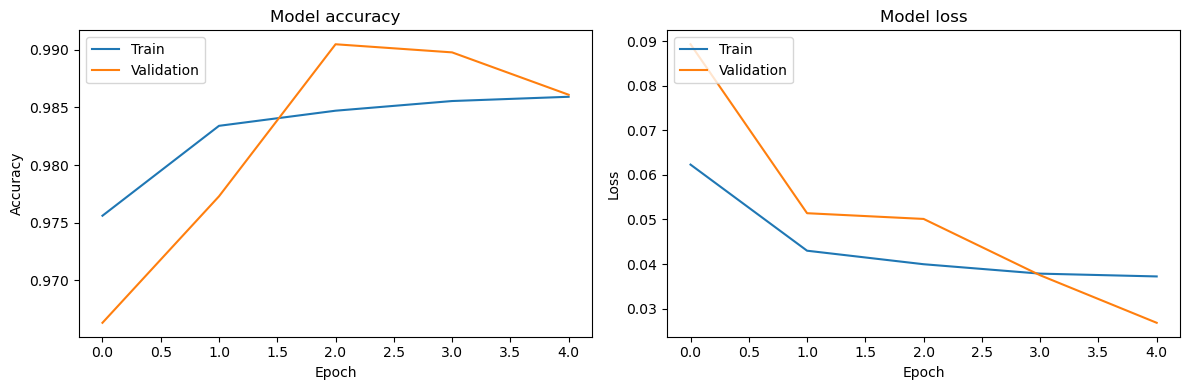

In [21]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()